In [2]:
import pyspark
from pyspark.sql import SQLContext
sqlContext = pyspark.SQLContext(sc)

#load data
loan_df = sqlContext.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true')\
    .load("/Users/niniliu/Documents/EECS6893/Project/EECS 6893 Project/integrated_data.csv")

In [3]:
#interpret HPI index
#loan_df = loan_df.withColumn('HPI_var',(loan_df['HPI_MAX']-loan_df['HPI_MIN'])/loan_df['HPI_ORIG'])
loan_df = loan_df.withColumn('HPI_inc',loan_df['HPI_MAX']/loan_df['HPI_ORIG'])
loan_df = loan_df.withColumn('HPI_dec',loan_df['HPI_ORIG']/loan_df['HPI_MIN'])

In [4]:
#transform loan data
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

categorical = ['FIRST_TIME_HOME_BUYER_FLAG','OCCUPANCY_STATUS','CHANNEL','PROP_TYPE',
               'LOAN_PURPOSE','SUPER_CONFORMING_FLAG']
numeric = ['FICO','MORTGAGE_INSURANCE_PCT','NUM_OF_UNITS',
           'LOAN_SIZE','ORGN_LTV','ORGN_RATE','NUM_OF_BORROWERS','HPI_ORIG',
           'HPI_inc','HPI_dec','IND_DEFAULT_2']

stringindexers = [StringIndexer(inputCol=x, outputCol='StringIndex_'+x) for x in categorical]
onehotencoders = [OneHotEncoder(inputCol='StringIndex_'+x, outputCol='OneHotEncoder_'+x) for x in categorical]
stages = stringindexers + onehotencoders

#build pipeline model
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)

pipeline_mode = pipeline.fit(loan_df)
df_coded = pipeline_mode.transform(loan_df)

#filter useful data
selected_columns = ['OneHotEncoder_'+x for x in categorical] + numeric
df_coded = df_coded.select(selected_columns)

df_coded.show(5)

+----------------------------------------+------------------------------+---------------------+-----------------------+--------------------------+-----------------------------------+-----+----------------------+------------+---------+--------+---------+----------------+--------+------------------+------------------+-------------+
|OneHotEncoder_FIRST_TIME_HOME_BUYER_FLAG|OneHotEncoder_OCCUPANCY_STATUS|OneHotEncoder_CHANNEL|OneHotEncoder_PROP_TYPE|OneHotEncoder_LOAN_PURPOSE|OneHotEncoder_SUPER_CONFORMING_FLAG| FICO|MORTGAGE_INSURANCE_PCT|NUM_OF_UNITS|LOAN_SIZE|ORGN_LTV|ORGN_RATE|NUM_OF_BORROWERS|HPI_ORIG|           HPI_inc|           HPI_dec|IND_DEFAULT_2|
+----------------------------------------+------------------------------+---------------------+-----------------------+--------------------------+-----------------------------------+-----+----------------------+------------+---------+--------+---------+----------------+--------+------------------+------------------+-------------+
|   

In [6]:
#assemble vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *

feature_columns = df_coded.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns,outputCol='features')
df_features = assembler.transform(df_coded)

df_features.show(5)

(train,test) = df_features.select(col("IND_DEFAULT_2").alias("label"), "features").randomSplit([0.8, 0.2])

+----------------------------------------+------------------------------+---------------------+-----------------------+--------------------------+-----------------------------------+-----+----------------------+------------+---------+--------+---------+----------------+--------+------------------+------------------+-------------+--------------------+
|OneHotEncoder_FIRST_TIME_HOME_BUYER_FLAG|OneHotEncoder_OCCUPANCY_STATUS|OneHotEncoder_CHANNEL|OneHotEncoder_PROP_TYPE|OneHotEncoder_LOAN_PURPOSE|OneHotEncoder_SUPER_CONFORMING_FLAG| FICO|MORTGAGE_INSURANCE_PCT|NUM_OF_UNITS|LOAN_SIZE|ORGN_LTV|ORGN_RATE|NUM_OF_BORROWERS|HPI_ORIG|           HPI_inc|           HPI_dec|IND_DEFAULT_2|            features|
+----------------------------------------+------------------------------+---------------------+-----------------------+--------------------------+-----------------------------------+-----+----------------------+------------+---------+--------+---------+----------------+--------+---------------

## Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import *



nb = NaiveBayes(smoothing=0.5, modelType="multinomial")
model = nb.fit(train)
predictions = model.transform(test)
predictions.show(5)

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
#predictions.show(5,False)
print("Test set accuracy = " + str(accuracy))

## Random Forest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)
rf_predictions.show(5)

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(rf_predictions)
#rf_predictions.show(5)
print("Test set accuracy = " + str(accuracy))

In [ ]:
rf_predictions.where(col("label")==1).show()

## Random Forest Regressor

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df_features)

# Train a RandomForest model.
rf_reg = RandomForestRegressor(featuresCol="indexedFeatures")

# Chain indexer and forest in a Pipeline
rf_pipeline = Pipeline(stages=[featureIndexer, rf_reg])

# Train model.  This also runs the indexer.
rfreg_model = rf_pipeline.fit(train)

# Make predictions.
rfreg_predictions = rfreg_model.transform(test)

# Select example rows to display.
rfreg_predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
rfreg_evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = rfreg_evaluator.evaluate(rfreg_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+--------------------+-----+--------------------+
|          prediction|label|            features|
+--------------------+-----+--------------------+
| 0.03201533162816545|    0|(25,[0,2,4,7,12,1...|
|0.017692284740118226|    0|(25,[0,2,4,7,12,1...|
|0.010411475435835685|    0|(25,[0,2,4,7,12,1...|
| 0.01602776084161051|    0|(25,[0,2,4,7,12,1...|
|0.015929442283545883|    0|(25,[0,2,4,7,12,1...|
+--------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.0820604


AUC is 0.800412568762


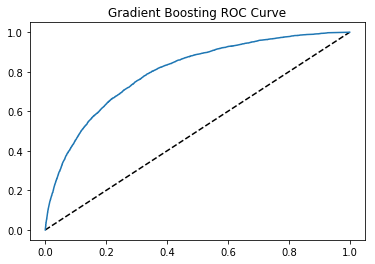

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
%matplotlib inline

rfreg_fpr, rfreg_tpr, rfreg_threshold = roc_curve(rfreg_predictions.select("label").collect(), 
                                         rfreg_predictions.select("prediction").collect())

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rfreg_fpr, rfreg_tpr)
plt.title('Gradient Boosting ROC Curve')
print('AUC is {}'.format(roc_auc_score(rfreg_predictions.select("label").collect(), 
                                         rfreg_predictions.select("prediction").collect())))